<a href="https://colab.research.google.com/github/luisovillista/LEO/blob/main/ENE_JUN_25_ILI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analisis 24


In [14]:
# -----------------------------------------
# pip install pandas matplotlib geopandas folium geopy plotly==5

In [15]:

# =========================================
# 1. Imports & setup
# -----------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import geopandas as gpd
import folium
from geopy.geocoders import Nominatim
import time

plt.rcParams["figure.dpi"] = 120

CSV_URL = (
    "https://raw.githubusercontent.com/luisovillista/LEO/refs/heads/main/ENE_JUN_25.csv"
)


In [16]:
# =========================================
# 2. Carga + limpieza express
# -----------------------------------------
df = pd.read_csv(CSV_URL)

def clean_text(s):
    return s.strip().title().replace("Ñ", "N") if isinstance(s, str) else s

df["Municipality"]  = df["Municipality"].apply(clean_text)
df["Establishment"] = df["Establishment"].apply(clean_text)
df = df.drop_duplicates(subset=["License Number"])

money_cols = [
    "Amount Played", "Amount Won", "Net Wager", "Funds In", "Funds Out",
    "Net Terminal Income", "NTI Tax", "State Share", "Municipality Share"
]
df[money_cols] = df[money_cols].apply(pd.to_numeric, errors="coerce")

df["NTI_per_VGT"]      = df["Net Terminal Income"] / df["VGT Count"]
df["Return_to_Player"] = df["Amount Won"] / df["Amount Played"]

agg = (
    df.groupby("Municipality")
      .agg(
          VGTs_total        = ("VGT Count", "sum"),
          NTI_total         = ("Net Terminal Income", "sum"),
          NTI_prom_por_VGT  = ("NTI_per_VGT", "mean"),
          Retorno_promedio  = ("Return_to_Player", "mean")
      )
      .reset_index()
      .sort_values("NTI_total", ascending=False)
)


	📊 Análisis Exploratorio - Gráficos Estáticos

Conjunto de visualizaciones básicas (barras, dispersión y distribución) que permite identificar rápidamente
a) los condados con mayor ingreso neto (NTI),
b) la relación entre número de máquinas y recaudación, y
c) la variabilidad en el retorno al jugador. Es el primer filtro para detectar focos de oportunidad o saturación.

✨ Analítica Interactiva - Plotly

Burbujas y treemap dinámicos que facilitan el “drill-down” sobre cada condado: las burbujas muestran volumen (NTI total) y eficiencia (NTI por máquina) en un mismo plano; el treemap revela la participación relativa de cada condado dentro del portafolio global.


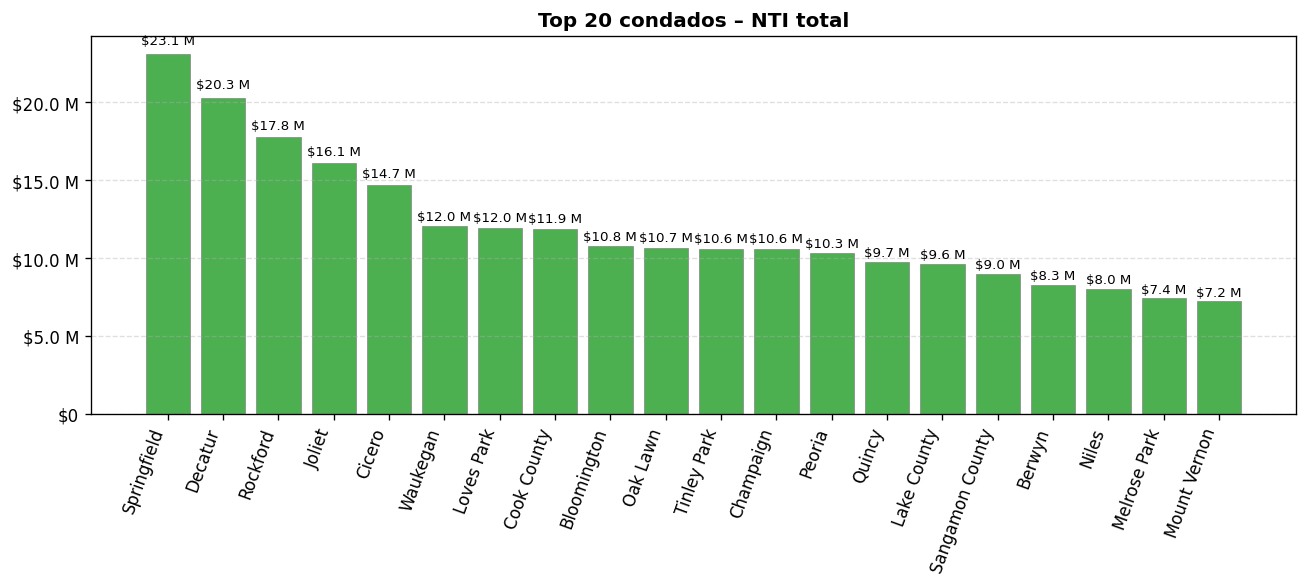

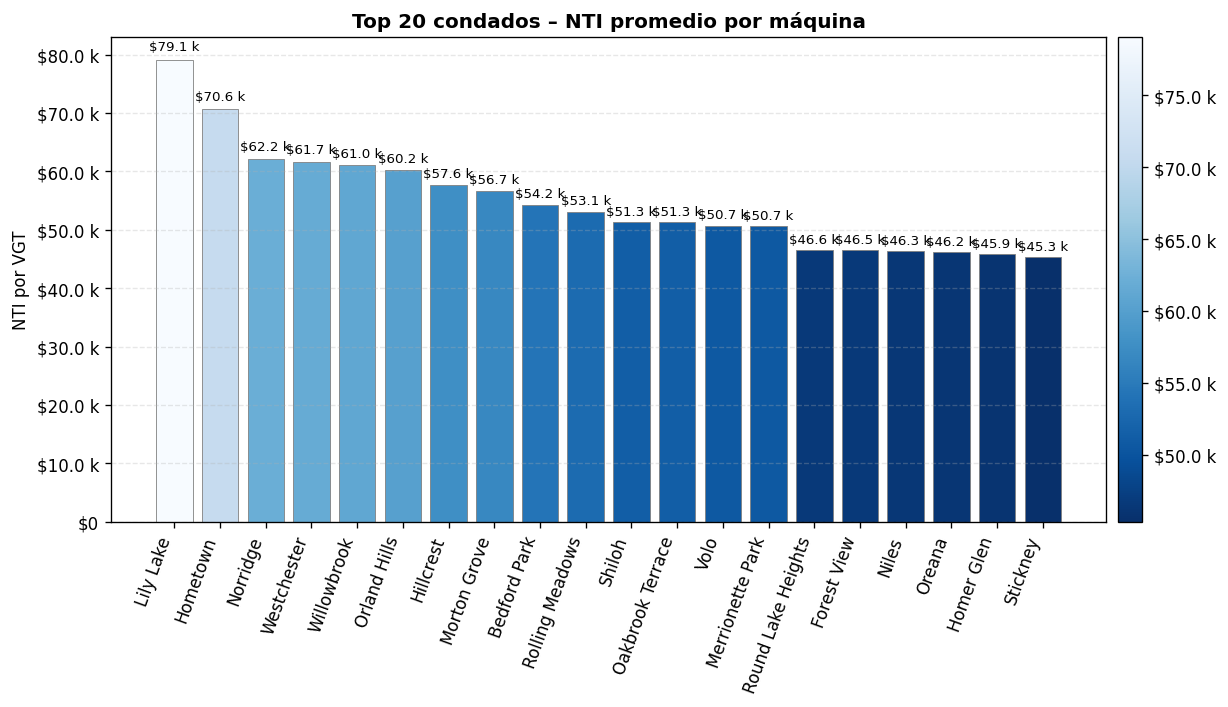

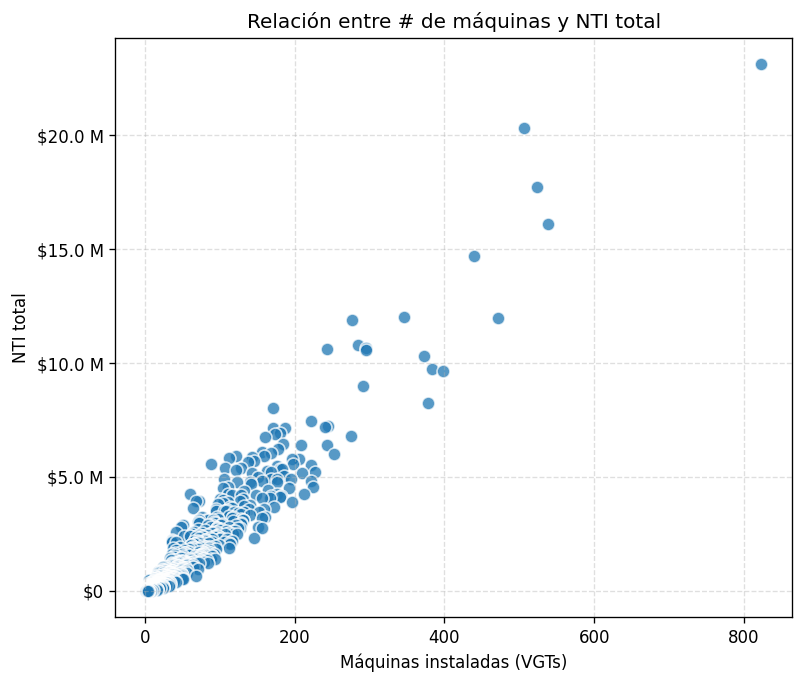

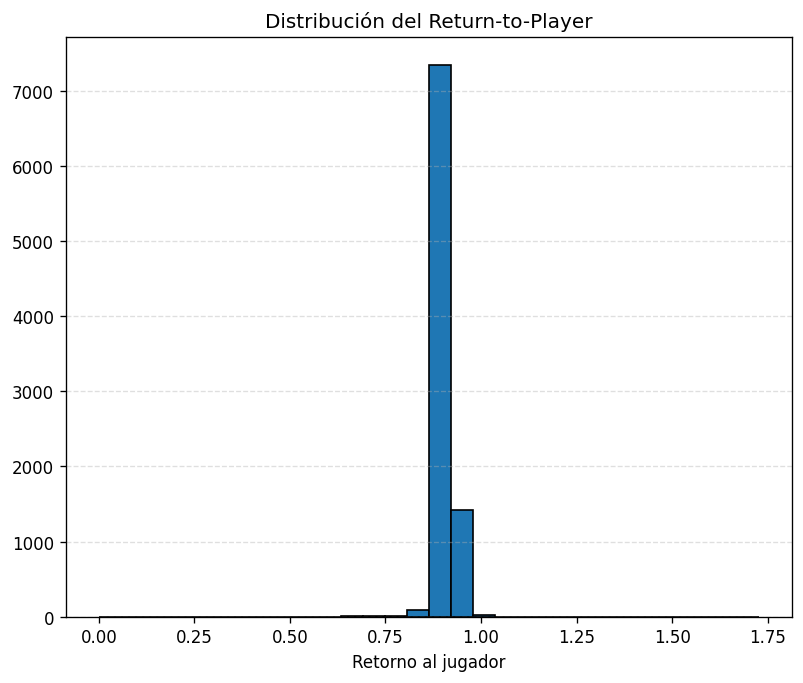

In [17]:
# -----------------------------------------
# 3. Gráficos estáticos rápidos (Matplotlib) –
# -----------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter

# ───────── Helpers ────────────────────────────────────────────
def human_fmt(x, pos=None):
    """Abrevia valores monetarios: 1 234 567 → $1.2 M   |   45 678 → $45.7 k"""
    if x >= 1_000_000:
        return f'${x/1_000_000:.1f} M'
    elif x >= 1_000:
        return f'${x/1_000:.1f} k'
    else:
        return f'${x:.0f}'

money_short = FuncFormatter(human_fmt)

# -----------------------------------------
# A) Top-20 NTI total por condado
# -----------------------------------------
top_total = agg.head(20)

fig, ax = plt.subplots(figsize=(11, 5))
bars = ax.bar(
    top_total["Municipality"],
    top_total["NTI_total"],
    color="#4caf50",
    edgecolor="grey",
    linewidth=0.4
)
ax.yaxis.set_major_formatter(money_short)
ax.set_title("Top 20 condados – NTI total", fontweight="bold")
ax.grid(axis="y", linestyle="--", alpha=0.4)
plt.setp(ax.get_xticklabels(), rotation=70, ha="right")

for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        h * 1.02,
        human_fmt(h),
        ha="center",
        va="bottom",
        fontsize=8,
    )

fig.tight_layout()
plt.show()

# -----------------------------------------
# B) Top-20 NTI promedio por máquina (degradado Blues)
# -----------------------------------------
top_vgt = agg.sort_values("NTI_prom_por_VGT", ascending=False).head(20)

cmap   = plt.cm.Blues_r
norm   = plt.Normalize(top_vgt["NTI_prom_por_VGT"].min(),
                       top_vgt["NTI_prom_por_VGT"].max())
colors = cmap(norm(top_vgt["NTI_prom_por_VGT"].values))

fig, ax = plt.subplots(figsize=(11, 6))
bars = ax.bar(
    top_vgt["Municipality"],
    top_vgt["NTI_prom_por_VGT"],
    color=colors,
    edgecolor="grey",
    linewidth=0.5
)

ax.yaxis.set_major_formatter(money_short)
ax.set_title("Top 20 condados – NTI promedio por máquina", fontweight="bold")
ax.set_ylabel("NTI por VGT")
ax.grid(axis="y", linestyle="--", alpha=0.3)
plt.setp(ax.get_xticklabels(), rotation=70, ha="right")

for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        h * 1.015,
        human_fmt(h),
        ha="center",
        va="bottom",
        fontsize=8,
    )

# Barra de color (leyenda) ——— ahora anclada al eje ax
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, pad=0.01).ax.yaxis.set_major_formatter(money_short)

fig.tight_layout()
plt.show()

# -----------------------------------------
# C) Dispersión – VGTs vs NTI total
# -----------------------------------------
fig, ax = plt.subplots(figsize=(6.8, 5.8))
ax.scatter(
    agg["VGTs_total"],
    agg["NTI_total"],
    alpha=0.75,
    s=60,
    edgecolors="white"
)
ax.yaxis.set_major_formatter(money_short)
ax.set_xlabel("Máquinas instaladas (VGTs)")
ax.set_ylabel("NTI total")
ax.set_title("Relación entre # de máquinas y NTI total")
ax.grid(True, linestyle="--", alpha=0.4)
fig.tight_layout()
plt.show()

# -----------------------------------------
# D) Histograma del Return-to-Player
# -----------------------------------------
rtp_clean = (
    df["Return_to_Player"]
      .replace([np.inf, -np.inf], np.nan)
      .dropna()
)

fig, ax = plt.subplots(figsize=(6.8, 5.8))
ax.hist(rtp_clean, bins=30, edgecolor="black")
ax.set_xlabel("Retorno al jugador")
ax.set_title("Distribución del Return-to-Player")
ax.grid(axis="y", linestyle="--", alpha=0.4)
fig.tight_layout()
plt.show()




	🗺️ Choropleth Rendimiento Verde-Amarillo-Rojo

Mapa temático de EE. UU. en el que cada condado se colorea según su NTI: verde intenso indica alto rendimiento, amarillo desempeño medio y rojo baja rentabilidad. Incluye leyenda continua y tooltips con el valor exacto, lo que permite evaluar la competitividad geográfica de un vistazo.

In [18]:
# =========================================================
# 5. Choropleth – Illinois (verde = mejor, rojo = peor)
# =========================================================
from IPython.display import display
import branca.colormap as bcm

try:
    COUNTY_GEO = (
        "https://raw.githubusercontent.com/"
        "python-visualization/folium/main/tests/us-counties.json"
    )
    counties = gpd.read_file(COUNTY_GEO)

    # 1) Filtra solo condados de Illinois (FIPS prefix "17")
    counties = counties[counties["id"].str.startswith("17")]

    # 2) Limpia nombres y hace merge con tus datos
    agg["County_clean"] = (
        agg["Municipality"]
          .str.replace(r"\s+County$", "", regex=True)
          .str.title()
    )
    map_df = counties.merge(
        agg, left_on="name", right_on="County_clean", how="left"
    )

    # 3) Colormap RdYlGn (rojo→amarillo→verde)
    min_val = map_df["NTI_total"].min()
    max_val = map_df["NTI_total"].max()
    colormap = bcm.linear.RdYlGn_09.scale(min_val, max_val)
    colormap.caption = "NTI total por condado (USD)"

    m = folium.Map(location=[40.0, -89.0], zoom_start=6.3)
    colormap.add_to(m)

    def style_fn(feature):
        name  = feature["properties"]["name"]
        value = map_df.loc[map_df["name"] == name, "NTI_total"].values
        color = colormap(value[0]) if len(value) and pd.notnull(value[0]) else "#cccccc"
        return {"fillOpacity": 0.7, "weight": 0.2, "fillColor": color, "color": "black"}

    folium.GeoJson(
        map_df,
        name="NTI_IL",
        style_function=style_fn,
        tooltip=folium.features.GeoJsonTooltip(
            fields=["name", "NTI_total"],
            aliases=["Condado", "NTI total"],
            localize=True
        ),
    ).add_to(m)

    m.save("IL_choropleth_NTI.html")
    print("🔥 Choropleth guardado como IL_choropleth_NTI.html")

    display(m)
except Exception as e:
    print("No se generó choropleth:", e)


🔥 Choropleth guardado como IL_choropleth_NTI.html


🔵 Mapa de Burbujas con Gradiente de Color

Visualización geoespacial que superpone burbujas sobre el centroide de cada condado. El radio refleja el NTI total (volumen de mercado) y el color sigue la misma escala verde-amarillo-rojo del choropleth (calidad del ingreso).


In [19]:
# =========================================================
# 6. Mapa de burbujas – Illinois (verde = top, rojo = flop)
# =========================================================
from IPython.display import display
import branca.colormap as bcm

try:
    # map_df viene del choropleth e incluye solo Illinois
    bubble_df = map_df.dropna(subset=["NTI_total"]).copy()
    bubble_df["lon"] = bubble_df.geometry.centroid.x
    bubble_df["lat"] = bubble_df.geometry.centroid.y

    # Mismo gradiente RdYlGn
    min_val = bubble_df["NTI_total"].min()
    max_val = bubble_df["NTI_total"].max()
    colormap = bcm.linear.RdYlGn_09.scale(min_val, max_val)
    colormap.caption = "NTI total por condado (USD)"

    bmap = folium.Map(location=[40.0, -89.0], zoom_start=6.3)
    colormap.add_to(bmap)

    for _, row in bubble_df.iterrows():
        folium.CircleMarker(
            location=[row["lat"], row["lon"]],
            radius=max(row["NTI_total"] / 1e6, 3),
            color=colormap(row["NTI_total"]),
            fill=True,
            fill_color=colormap(row["NTI_total"]),
            fill_opacity=0.75,
            popup=f"{row['name']} County:<br>${row['NTI_total']:,.0f}"
        ).add_to(bmap)

    bmap.save("IL_burbujas_NTI.html")
    print("✅ Mapa burbujas guardado como IL_burbujas_NTI.html")

    display(bmap)
except Exception as e:
    print("No se generó el mapa de burbujas:", e)


/tmp/ipython-input-19-2835934041.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bubble_df["lon"] = bubble_df.geometry.centroid.x
/tmp/ipython-input-19-2835934041.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bubble_df["lat"] = bubble_df.geometry.centroid.y


✅ Mapa burbujas guardado como IL_burbujas_NTI.html


In [20]:
# =========================================================
# 7. Exporta tablas y muestra resumen
# =========================================================
from IPython.display import display
import os

# --- 7-A  Guarda todo en un solo Excel --------------------
OUT_XLSX = "resumen_municipios.xlsx"
with pd.ExcelWriter(OUT_XLSX) as writer:
    # Hoja 1: todos los condados con métricas
    agg.to_excel(writer, sheet_name="Resumen_Completo", index=False)

    # Hoja 2: Top 20 en NTI total
    agg.sort_values("NTI_total", ascending=False).head(20)\
       .to_excel(writer, sheet_name="Top20_NTI_total", index=False)

    # Hoja 3: Top 20 en NTI por máquina
    agg.sort_values("NTI_prom_por_VGT", ascending=False).head(20)\
       .to_excel(writer, sheet_name="Top20_NTIxVGT", index=False)

print(f"💾 Excel exportado: {OUT_XLSX}  ({os.path.getsize(OUT_XLSX)/1024:.1f} KB)")

# --- 7-B  Copia ligera a CSV (por si acaso) ---------------
agg.to_csv("resumen_municipios.csv", index=False)

# --- 7-C  Vista previa en el cuaderno ---------------------
print("🔍 Top 10 condados por NTI total")
display(
    agg.sort_values("NTI_total", ascending=False).head(10)
          .style.format({"NTI_total":"${:,.0f}",
                         "NTI_prom_por_VGT":"${:,.0f}",
                         "Retorno_promedio":"{:.2%}"})
)



💾 Excel exportado: resumen_municipios.xlsx  (65.5 KB)
🔍 Top 10 condados por NTI total


,Municipality,VGTs_total,NTI_total,NTI_prom_por_VGT,Retorno_promedio,County_clean
897,Springfield,823.000000,"$23,119,859","$26,842",91.19%,Springfield
244,Decatur,506.000000,"$20,315,106","$39,311",91.04%,Decatur
820,Rockford,523.000000,"$17,751,295","$32,462",90.99%,Rockford
468,Joliet,538.000000,"$16,128,769","$28,053",90.90%,Joliet
186,Cicero,439.000000,"$14,716,017","$32,436",90.61%,Cicero
1010,Waukegan,346.000000,"$12,036,350","$33,644",90.55%,Waukegan
540,Loves Park,471.000000,"$11,959,838","$24,796",90.55%,Loves Park
209,Cook County,277.000000,"$11,875,720","$41,709",92.54%,Cook
88,Bloomington,285.000000,"$10,776,247","$36,578",91.22%,Bloomington
696,Oak Lawn,296.000000,"$10,671,932","$35,197",90.43%,Oak Lawn
